# **1.Conectamos Colab con Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
PATH_ORIGEN = "/content/drive/MyDrive/Electivos/IAA/Proyecto/code/dataset/BraTS-2020"
os.chdir(PATH_ORIGEN)
sys.path.append(os.path.abspath(PATH_ORIGEN))

In [5]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 3.9MB 53.3MB/s 
     |████████████████████████████████| 450kB 48.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=fa2012991a01b436a3cf9d60be9d6a7e5bd4b2e5df7f601c75571ed71bc7b6c0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

In [42]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import visualization
import patch
import model3
import generate
import preprocessing
import metrics
from tqdm import tqdm
import seg_eval_wt

In [7]:
print(tf.__version__)
print(keras.__version__)
## 2.1.0
## 2.3.1

2.1.0
2.3.1


In [ ]:
!nvidia-smi

In [ ]:
!nvidia-smiPS -fA | grep pythonkill -9 PID

# **2.Definimos el modelo**

## **2.1.Función de pérdida**

In [8]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):


    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true**2, axis=axis) + K.sum(y_pred**2, axis=axis) + epsilon
    dice_loss = 1 - K.mean((dice_numerator)/(dice_denominator))
    
    return dice_loss

## **2.2.Métrica**

In [9]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    

    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true, axis=axis) + K.sum(y_pred, axis=axis) + epsilon
    dice_coefficient = K.mean((dice_numerator)/(dice_denominator))
    
    return dice_coefficient

## **2.3.Arquitectura**

In [10]:
model = model3.resunet_model_3d(loss_function=soft_dice_loss, metrics=[dice_coefficient])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 160, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 160, 160, 6976        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 160, 160, 64          conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 160, 160, 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## **2.4.Entrenando**

Colocar el siguiente código JavaScript en la consola del navegador que este usando para que Colab no se desconecte por tiempo de inactividad,además no olvidar de apagar la opción de hibernación de su computadora local.

```
function ClickConnect(){

console.log("Working"); 

document.querySelector("colab-toolbar-button#connect").click() 

}

setInterval(ClickConnect,60000)

```

In [12]:
base_dir = PATH_ORIGEN + "/DatasetFinal/processed/"

with open(base_dir + "config.json") as json_file:
    config = json.load(json_file)

In [13]:
PATH_WEIGHTS = "./pesos/ResUNet3D/Epoch-111-117/"

In [14]:
# Checkpoint
model_checkpoint = ModelCheckpoint(filepath = PATH_WEIGHTS + "model-{epoch:04d}-{val_loss:.4f}.hdf5", 
                                   monitor='val_loss',
                                   verbose=1, 
                                   save_best_only=False,
                                   #save_weights_only=False,
                                   save_freq='epoch'
                                   )
# History
csv_logger = CSVLogger(PATH_WEIGHTS + "model_history_log.csv", append=True)

In [15]:
# Generando dataset de entrenamiento y validacion
train_generator = generate.VolumeDataGenerator(config["train"], 
                                           base_dir + "train/", 
                                           batch_size=4, 
                                           dim=(160, 160, 16), 
                                           verbose=0)
valid_generator = generate.VolumeDataGenerator(config["valid"], 
                                            base_dir + "valid/", 
                                            batch_size=4, 
                                            dim=(160, 160, 16), 
                                            verbose=0)

In [16]:
steps_per_epoch = 16
n_epochs = 7
validation_steps = 16

In [19]:
history = model.fit_generator(generator=train_generator,
                steps_per_epoch = steps_per_epoch,
                epochs = n_epochs,
                callbacks=[model_checkpoint,csv_logger],
                use_multiprocessing=True,
                validation_data=valid_generator,
                validation_steps=validation_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 16 steps
Epoch 1/7
15/16 [===========================>..] - ETA: 6s - loss: 0.2215 - dice_coefficient: 0.6812 
Epoch 00001: saving model to ./pesos/ResUNet3D/Epoch-111-117/model-0001-0.2189.hdf5
16/16 [==============================] - 227s 14s/step - loss: 0.2194 - dice_coefficient: 0.6820 - val_loss: 0.2189 - val_dice_coefficient: 0.6590
Epoch 2/7
15/16 [===========================>..] - ETA: 6s - loss: 0.2015 - dice_coefficient: 0.6873 
Epoch 00002: saving model to ./pesos/ResUNet3D/Epoch-111-117/model-0002-0.2295.hdf5
16/16 [==============================] - 114s 7s/step - loss: 0.1994 - dice_coefficient: 0.6897 - val_loss: 0.2295 - val_dice_coefficient: 0.6517
Epoch 3/7
15/16 [===========================>..] - ETA: 6s - loss: 0.2172 - dice_coefficient: 0.6753 
Epoch 00003: saving model to ./pesos/ResUNet3D/Epoch-111-117/mode

## **2.5.Cargamos el modelo**

In [20]:
# Cargar la ruta del punto de control q se desea recuperar
checkpoint_filepath ="pesos/ResUNet3D/Epoch-111-117/model-0007-0.2102.hdf5"

In [21]:
# Cargamos los pesos
model.load_weights(checkpoint_filepath)

# **3.Métricas**

## **3.1.Soft dice loss y dice coefficient**

In [23]:
PATH_HISTORY = "./pesos/ResUNet3D/history_final.csv"
history = pd.read_csv(PATH_HISTORY)

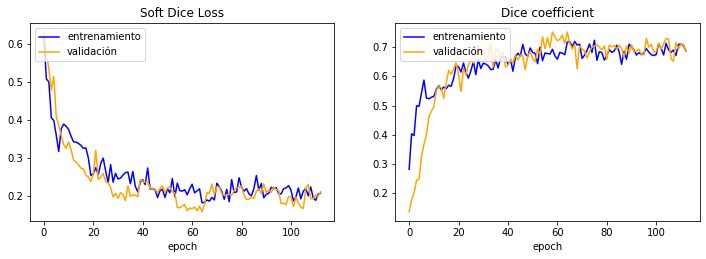

In [24]:
# GRAFICANDO resultados
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)

# plot loss
plt.subplot(2,2,1)
plt.title('Soft Dice Loss')
plt.xlabel("epoch")
plt.plot(history['loss'], color='blue', label='train')
plt.plot(history['val_loss'],color ='orange',label='validation')
plt.legend(['entrenamiento', 'validación'], loc='upper left')

# plot dice coefficient
plt.subplot(2,2,2)
plt.title('Dice coefficient')
plt.xlabel("epoch")
plt.plot(history['dice_coefficient'], color='blue', label='train')
plt.plot(history['val_dice_coefficient'], color='orange', label='validation')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [22]:
val_loss, val_dice = model.evaluate_generator(valid_generator)
print(f"validation soft dice loss: {val_loss:.4f}")
print(f"validation dice coefficient: {val_dice:.4f}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
validation soft dice loss: 0.2028
validation dice coefficient: 0.6938


# **4.Visualización del dataset de validación**

In [50]:
image, label = preprocessing.load_case("DatasetFinal/imagesTr/train/BraTS20_Training_002_total.nii", 
                         "DatasetFinal/labelsTr/train/BraTS20_Training_002_segf.nii")

In [51]:
start_x,start_y,start_z,X,y = preprocessing.get_sub_volume(image,label)

In [52]:
X_norm = preprocessing.standardize(X)

(array([0., 1.], dtype=float32), array([408029,   1571]))


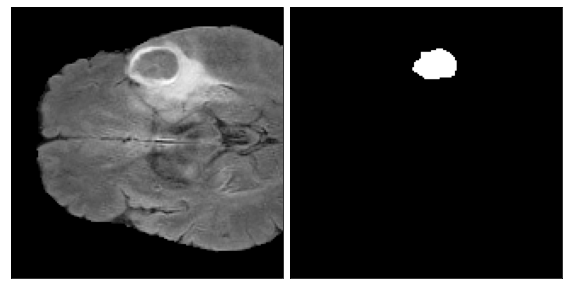

In [53]:
# NUCLEO DEL TUMOR
visualization.visualize_patch(X_norm[0, :, :, :], y[0])
print(np.unique(y[0],return_counts=True))

(array([0., 1.], dtype=float32), array([389997,  19603]))


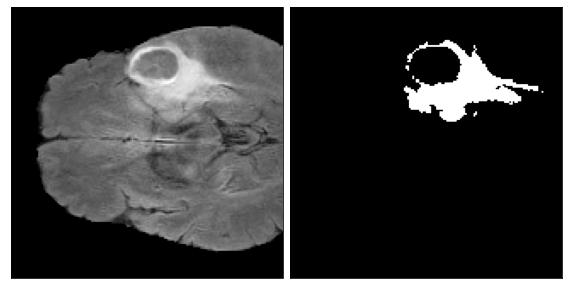

In [54]:
# EDEMA PERITUMORAL
visualization.visualize_patch(X_norm[0, :, :, :], y[1])
print(np.unique(y[1],return_counts=True))

(array([0., 1.], dtype=float32), array([407701,   1899]))


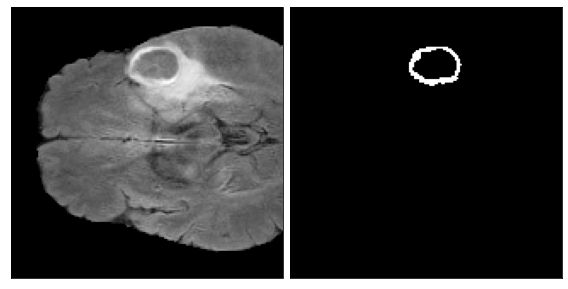

In [55]:
# TUMOR REALZADO
visualization.visualize_patch(X_norm[0, :, :, :], y[2])
print(np.unique(y[2],return_counts=True))

In [56]:
# Prediccion sobre la validacion
# Agregamos una dimension mas --> X_norm debe ser de la forma(batch_size,num_channels,x_dim,y_dim,z_dim)
X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
print(X_norm_with_batch_dimension.shape)

(1, 4, 160, 160, 16)


In [57]:
# Prediccion
patch_pred = model.predict(X_norm_with_batch_dimension)

# **5.Inferencia**

In [58]:
# Umbral para la predicción
threshold = 0.5
patch_pred[patch_pred > threshold] = 1.0  # clase tumor
patch_pred[patch_pred <= threshold] = 0.0 # clase no tumor

## **5.1.Métricas**

Dado el umbral de predicción de la red neuronal se procederá a calcular el accuracy,precision y recall.

In [67]:
accuracy_TC,precision_TC,recall_TC = metrics.metric_class(patch_pred[0],y,0) # Nucleo del tumor
accuracy_ED,precision_ED,recall_ED = metrics.metric_class(patch_pred[0],y,1) # Edema peritumoral
accuracy_ET,precision_ET,recall_ET = metrics.metric_class(patch_pred[0],y,2)  # tumor realzado

In [ ]:
patch_metrics = metrics.get_metrics_df(patch_pred[0],y)
patch_metrics

In [40]:
# Dataset de validación
PATH_VAL = "./DatasetFinal/processed/valid/"
validation = config['valid']

In [ ]:
PATH_METRICS = "/content/drive/MyDrive/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/DatasetFinal/processed/train/"

In [43]:
### Métricas globales ####
### Accuracy,Precision,Recall y Dice por cada máscara ####
accuracy_TC =[]
accuracy_WT =[]
accuracy_ET =[]

sensibilidad_TC =[]
sensibilidad_WT =[]
sensibilidad_ET =[]

especificidad_TC =[]
especificidad_WT =[]
especificidad_ET = []

dice_TC =[]
dice_WT =[]
dice_ET =[]

long_valid = len(validation)

for i in tqdm(range(long_valid)):
  ruta = PATH_VAL + str(validation[i])
  with h5py.File(ruta, 'r') as f:

    data_x = f.get('x')
    data_y = f.get('y')

    X = np.array(data_x)
    y = np.array(data_y)
    y = np.moveaxis(y, 3, 0)[1:] # Excluimos la máscara de WT

    X_norm = preprocessing.standardize(X)
    X_norm_with_batch_dimension = np.expand_dims(X_norm, axis=0)
    patch_pred = model.predict(X_norm_with_batch_dimension)

    # Umbral
    threshold = 0.5
    patch_pred[patch_pred > threshold] = 1.0  # clase tumor
    patch_pred[patch_pred <= threshold] = 0.0 # clase no tumor

    # Hallamos el tumor completo como la suma de las máscaras

    # Para la máscara verdadera
    y_WT = y[0] + y[1] + y[2]
    y_WT = np.where(y_WT >= 1, 1, 0)

    # Para la máscara predicha
    patch_pred_WT = patch_pred[0,0, :, :, :] + patch_pred[0,1, :, :, :] + patch_pred[0,2, :, :, :]
    patch_pred_WT = np.where(patch_pred_WT >= 1, 1, 0)

    # Métricas
    a1,b1,c1,d1 = metrics.metric_class(patch_pred[0],y,0) # Accuracy,sensibilidad,especificidad y dice para TC
    #a2,b2,c2,d2 = metrics.metric_class(patch_pred[0],y,1) # Accuracy,sensibilidad,especificidad y dice para ED
    a2,b2,c2,d2 = seg_eval_wt.metric_class(patch_pred_WT,y_WT) # Accuracy,sensibilidad,especificidad y dice para WT
    a3,b3,c3,d3 = metrics.metric_class(patch_pred[0],y,2) # Accuracy,sensibilidad,especificidad y dice para ET

    accuracy_TC.append(round(a1,3)) 
    accuracy_WT.append(round(a2,3)) 
    accuracy_ET.append(round(a3,3)) 

    sensibilidad_TC.append(round(b1,3)) 
    sensibilidad_WT.append(round(b2,3)) 
    sensibilidad_ET.append(round(b3,3)) 

    especificidad_TC.append(round(c1,3)) 
    especificidad_WT.append(round(c2,3))
    especificidad_ET.append(round(c3,3))

    dice_TC.append(round(d1,3))
    dice_WT.append(round(d2,3))
    dice_ET.append(round(d3,3))

  3%|▎         | 37/1290 [00:30<19:28,  1.07it/s]/content/drive/.shortcut-targets-by-id/1LhjoA4gUbfSsTM8dqU3VR-wSCJXZt5nQ/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/metrics.py:39: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = (tp) / (tp + fn)
 11%|█         | 143/1290 [01:59<18:07,  1.05it/s]/content/drive/.shortcut-targets-by-id/1LhjoA4gUbfSsTM8dqU3VR-wSCJXZt5nQ/Electivos/IAA/Proyecto/code/dataset/BraTS-2020/metrics.py:41: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2*tp) /((2*tp)+fp+fn)
100%|██████████| 1290/1290 [19:35<00:00,  1.10it/s]


In [44]:
accuracy_TC_final = round(pd.Series(accuracy_TC).dropna().mean(),3) # Nucleo del tumor
accuracy_WT_final = round(pd.Series(accuracy_WT).dropna().mean(),3) # Edema peritumoral
accuracy_ET_final = round(pd.Series(accuracy_ET).dropna().mean(),3) # Tumor realzado

sensibilidad_TC_final = round(pd.Series(sensibilidad_TC).dropna().mean(),3) 
sensibilidad_WT_final = round(pd.Series(sensibilidad_WT).dropna().mean(),3)
sensibilidad_ET_final = round(pd.Series(sensibilidad_ET).dropna().mean(),3)

especificidad_TC_final = round(pd.Series(especificidad_TC).dropna().mean(),3) 
especificidad_WT_final = round(pd.Series(especificidad_WT).dropna().mean(),3)
especificidad_ET_final = round(pd.Series(especificidad_ET).dropna().mean(),3)

dice_TC_final = round(pd.Series(dice_TC).dropna().mean(),3)
dice_WT_final = round(pd.Series(dice_WT).dropna().mean(),3)
dice_ET_final = round(pd.Series(dice_ET).dropna().mean(),3)

In [45]:
acc = [accuracy_TC_final,accuracy_WT_final,accuracy_ET_final]
sens =[sensibilidad_TC_final,sensibilidad_WT_final,sensibilidad_ET_final]
spec =[especificidad_TC_final,especificidad_WT_final,especificidad_ET_final]
dice =[dice_TC_final,dice_WT_final,dice_ET_final]

In [46]:
metrics_final = pd.DataFrame(columns = ['Nucleo del tumor', 'Tumor completo', 'Tumor realzado'], index = ['Sensibilidad','Especificidad','Dice'])
    
for i, class_name in enumerate(metrics_final.columns):
    #metrics_final.loc['Accuracy', class_name] = acc[i]
    metrics_final.loc['Sensibilidad', class_name] = sens[i]
    metrics_final.loc['Especificidad', class_name] = spec[i]
    metrics_final.loc['Dice', class_name] = dice[i]

In [47]:
# Métricas finales del dataset de validación
metrics_final

,Nucleo del tumor,Tumor completo,Tumor realzado
Sensibilidad,0.699,0.868,0.66
Especificidad,0.989,0.995,0.999
Dice,0.49,0.893,0.696


# **6.Visualización de inferencia**

## **6.1.Para cada máscara**

In [59]:
# valor real de los pixeles
print(np.unique(y[0],return_counts=True)) # Nucleo del tumor
print(np.unique(y[1],return_counts=True)) # Edema peritumoral
print(np.unique(y[2],return_counts=True)) # Tumor realzado

(array([0., 1.], dtype=float32), array([408029,   1571]))
(array([0., 1.], dtype=float32), array([389997,  19603]))
(array([0., 1.], dtype=float32), array([407701,   1899]))


In [60]:
# Valor predicho de los pixeles
print(np.unique(patch_pred[0,0, :, :, :],return_counts=True)) # Nucleo del tumor
print(np.unique(patch_pred[0,1, :, :, :],return_counts=True)) # Edema peritumoral
print(np.unique(patch_pred[0,2, :, :, :],return_counts=True)) # Tumor realzado

(array([0., 1.], dtype=float32), array([405373,   4227]))
(array([0., 1.], dtype=float32), array([389123,  20477]))
(array([0., 1.], dtype=float32), array([408657,    943]))


Segmentacion real


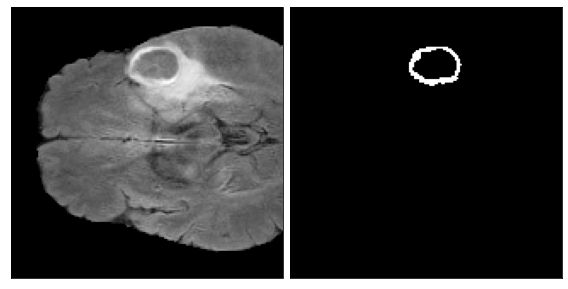

Segmentacion ResUnet


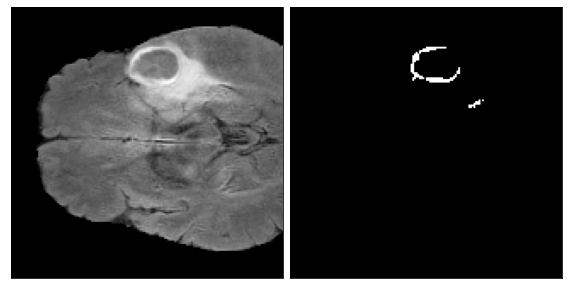

In [62]:
# X_norm :(secuencia,alto,ancho,profundidad)
# y: máscara (0->TC, 1->EDEMA, 2->ET)
print("Segmentacion real")  
visualization.visualize_patch(X_norm[0, :, :, :], y[2])
plt.show()
print("Segmentacion ResUnet")
visualization.visualize_patch(X_norm[0, :, :, :], patch_pred[0,2, :, :, :])
plt.show()

## **6.2.Para WT(Tumor completo)**

In [63]:
# Hallamos la máscara y_WT como la suma de las demás máscaras
y_WT = y[0] + y[1] + y[2]
y_WT = np.where(y_WT >= 1, 1, 0)

In [64]:
# Hallamos la predicción de la máscara y_WT como la suma de las demás máscaras
patch_pred_WT = patch_pred[0,0, :, :, :] + patch_pred[0,1, :, :, :] + patch_pred[0,2, :, :, :]
patch_pred_WT = np.where(patch_pred_WT >= 1, 1, 0)

Segmentacion real WT


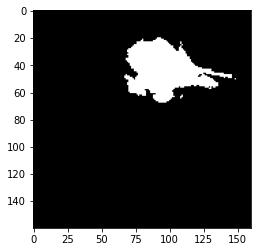

Segmentacion ResUnet WT


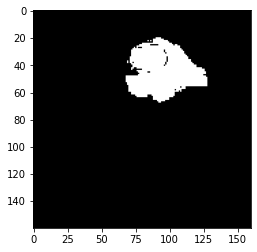

In [65]:
print("Segmentacion real WT")
plt.imshow(y_WT[:,:,0],cmap="gray")
plt.show()
print("Segmentacion ResUnet WT")
plt.imshow(patch_pred_WT[:,:,0],cmap="gray")
plt.show()

## **6.4.Para la IMR completa**

In [66]:
image, label = preprocessing.load_case("DatasetFinal/imagesTr/train/BraTS20_Training_002_total.nii", 
                         "DatasetFinal/labelsTr/train/BraTS20_Training_002_segf.nii")
visualization.predict_and_viz(image, label, model, .5)

Videos guardados correctamente


(<VideoWriter 0x7f2b0d226a10>, <VideoWriter 0x7f2b0db0def0>)